In [926]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim

In [927]:
# First, I define the game environment. Each player gets a suit of cards (13 total) with values of 1(ace)-13(king)
# There is one "prize" suit, which the players are bidding on. Every round, a card is revealed on the top of the
# shuffled prize deck, and each player secretly decides on a card to bid. The highest bidder takes the card. Ties result
# in the value of the prize being split. The goal is to get the highest value of prizes at the end of the game, when all
# prizes have been bid on.

# Each agent has almost perfect information, except for the order of the prize deck. The stochasticity of the game comes 
# into play from the randomly shuffled prize deck and the choice of the other agent.

class GOPS:
    def __init__(self, seed=None):
        self.reset(seed)
            
    def get_cur_state(self):
        return [self.prize_deck, self.p1, self.p2, self.faceup, self.last_winner, self.done]
      
    # For the agents that use encoded states, I only give the opponents have and the faceup card. Leaving out the prize deck doesn't affect much
    # and reduces the dimensionality of the state space
    def get_binary_encoded_state(self, S):
        p1_encode = np.zeros(13)
        p2_encode = np.zeros(13)
        for card in S[1]:
            p1_encode[card-1] = 1
        for card in S[2]:
            p2_encode[card-1] = 1
        faceup_encode = np.zeros(13)
        faceup_encode[S[3]-1] = 1
        state_encoding = np.append(p1_encode, p2_encode)
        state_encoding = np.append(state_encoding, faceup_encode)
        return state_encoding
    
    #Actions correspond to the card 
    def step(self, p1_action, p2_action):
        if(len(self.prize_deck)==0):
            self.done = True
            self.faceup = -1
        else:
            self.faceup = self.prize_deck[0]
            self.prize_deck.remove(self.faceup)
        self.p1.remove(p1_action)
        self.p2.remove(p2_action)
        if(p1_action>p2_action):
            self.last_winner = 1
        elif(p2_action>p1_action):
            self.last_winner = 2
        else:
            self.last_winner = 0
        return self.get_cur_state()
    
    # prize_deck: the remaining cards in the prize deck
    # p1: the cards in player 1's hand
    # p2: the cars in player 2's hand
    # faceup: the current prize to be bid on
    # last_winner: The winner of the previous round (0 if tie, 1 if player1, 2 if player2)
    def reset(self, seed=None):
        self.prize_deck = [1,2,3,4,5,6,7,8,9,10,11,12,13]
        self.p1 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
        self.p2 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
        if(seed!=None):
            Random.random(seed).shuffle(self.prize_deck)
        else:
            random.shuffle(self.prize_deck)
        self.faceup = self.prize_deck[0]
        self.prize_deck.remove(self.faceup)
        self.last_winner = None
        self.done = False
        return self.get_cur_state()
        

In [928]:
# Agent 1 - counter to the random policy
# This agent will serve as the baseline against all the other agents. Any learning agent should figure out its strategy
# and outpreform this agent. This agent always bets the same value as the card shown on the top of the prize deck. This
# Agent is the best counter to a random strategy.

class Baseline:
    def __init__(self, player_status):
        self.player_status = player_status
        self.score = 0

    def actionSelect(self, S, G):
        faceup = S[3]
        action = faceup
        return action
    
    def addScore(self, value):
        self.score = self.score + value
    
    def getScore(self):
        return self.score
    
    def reset(self):
        self.score = 0
    def report_winner(self, winner, prize):
        None

In [929]:
# Agent 2 - Random Agent
# this agent selects a random card to bid on the prize card
# Player status: Is this player 1 or player 2? 1=p1, 2=p2
class RandomAgent:
    
    def __init__(self, player_status):
        self.player_status = player_status
        self.score = 0
        
    def actionSelect(self, S, G):
        return random.choice(S[self.player_status])
    
    def addScore(self, value):
        self.score = self.score + value
        
    def getScore(self):
        return self.score
    
    def reset(self):
        self.score = 0
    def report_winner(self, winner, prize):
        None

In [930]:
# Agent 3 - Monte-carlo
# This algorithm assumes some policy of the opponent, freezes it in time, and simulates games to update the value
# function approximation (I'm using linear function approximation)
# Perhaps value based methods rather than policy based methods will be better suited to dealing with a discrete game
# like GOPS.
# We may need to train an approximation of the opponent policy, that is we create a value function for the opponent
# based on what we see them play. We update these weights every time we play against them, then keep them static when
# generating new episodes in the monte-carlo approach.

class MC_agent:
    def __init__(self, lr, player_status, opp_status):
        self.player_status = player_status
        self.opp_status = opp_status
        self.score = 0
        self.lr = lr
        self.last_S = None
        # state-action value approximation- action taken has high impact here. Maybe training time increases and I
        # increase learning rate.
        self.w = np.random.uniform(low=-0.001, high=0.001, size=(39,13))
        self.opponent = np.random.uniform(low=-0.001, high=0.001, size=(39))
    
    # Following an epsilon greedy policy
    def simluate_games(self, S, G, num_games, epsilon):
        S_orig = S
        for i in range(0,num_games):
            # I take a copy of the current state in the game so I can play it out
            fake_game = copy.deepcopy(G)
            cur_val = self.score
            done = S_orig[5]
            S = S_orig
            state_action_record = []
            while(not done):
                opp_action = self.opponent_action(S, fake_game)
                encoding = fake_game.get_binary_encoded_state(S)
                prize = S[3]
                action_values = np.zeros(13)
                for j in range(0,13):
                    action_values[j] = encoding.dot(self.w[:,j])
                exploreRoll = random.random()
                player_action = 0
                if exploreRoll<epsilon:
                    player_action = random.choice(S[self.player_status])
                else:
                    player_action = np.argmax(action_values)+1
                if(player_action not in S[self.player_status]):
                    player_action = random.choice(S[self.player_status])
                if(self.player_status == 1):
                    next_S = fake_game.step(player_action, opp_action)
                else:
                    next_S = fake_game.step(opp_action, player_action)
                last_winner = next_S[4]
                if(last_winner == 0):
                    cur_val += (prize/2)
                    state_action_record.append((S, player_action, prize/2))
                elif(last_winner == self.player_status):
                    cur_val += prize
                    state_action_record.append((S, player_action, prize))
                else:
                    state_action_record.append((S, player_action, 0))
                done = next_S[5]
                S = next_S
            # Now here, I update the weights based on the incremental rewards
            # I update based on every state-action pair I collected. No need to worry about cycles, there are a limited
            # number of steps that can be taken- 13 max.
            for pair in state_action_record:
                # I only update the weights positively if we win in the end
                if(cur_val < 46):
                    encoding = G.get_binary_encoded_state(pair[0])
                    #self.w[:,pair[1]-1] = self.w[:,pair[1]-1]+self.lr*(-10-encoding.dot(self.w[:,pair[1]-1]))*encoding
                    self.w[:,pair[1]-1] = self.w[:,pair[1]-1]+self.lr*(cur_val-np.dot(np.transpose(self.w[:,pair[1]-1]), encoding))*encoding
                else:
                    encoding = G.get_binary_encoded_state(pair[0])
                    #self.w[:,pair[1]-1] = self.w[:,pair[1]-1]+self.lr*(pair[2]-encoding.dot(self.w[:,pair[1]-1]))*encoding
                    self.w[:,pair[1]-1] = self.w[:,pair[1]-1]+self.lr*(cur_val-np.dot(np.transpose(self.w[:,pair[1]-1]), encoding))*encoding
                     
    # We assume the opponent takes their best action, based on our current understanding of their strategy
    def opponent_action(self, S, G):
        action_values = np.zeros(13)
        encoding = G.get_binary_encoded_state(S)
        opp_action = round(encoding.dot(self.opponent))
        if(opp_action == 0):
            opp_action=1
        if(opp_action not in S[self.opp_status]):
            opp_action = random.choice(S[self.opp_status])
        return opp_action
    
    # I need a reference to the game object so I can simulate episodes
    # The agent will follow a greedy policy in the actual step
    def actionSelect(self, S, G):
        if(S[4]==None):
            self.last_S=None
        self.simluate_games(S, G, 5, (1/16))
        encoding = G.get_binary_encoded_state(S)
        last_encoding = None
        if(self.last_S is not None):
            last_encoding = G.get_binary_encoded_state(self.last_S)
        vals = np.zeros(13)
        for i in range(0,13):
            if(i+1 not in S[self.player_status]):
                continue
            else:
                vals[i] = encoding.dot(self.w[:,i])
        action = np.argmax(vals)+1
        if(action not in S[self.player_status]):
            action = random.choice(S[self.player_status])
        if(self.last_S!=None):
            last_opp_action = list(set(self.last_S[self.opp_status]) - set(S[self.opp_status]))[0]
            self.opponent = self.opponent + self.lr*(last_opp_action-last_encoding.dot(self.opponent))*last_encoding
            last_player_action = list(set(self.last_S[self.player_status]) - set(S[self.player_status]))[0]
            if(S[4]==self.player_status):
                self.w[:,last_player_action-1] = self.w[:,last_player_action-1]+self.lr*(self.last_S[3]-last_encoding.dot(self.w[:,last_player_action-1]))*last_encoding
            elif(S[4]==0):
                self.w[:,last_player_action-1] = self.w[:,last_player_action-1]+self.lr*((self.last_S[3]/2)-last_encoding.dot(self.w[:,last_player_action-1]))*last_encoding
            else:
                self.w[:,last_player_action-1] = self.w[:,last_player_action-1]+self.lr*(-10-last_encoding.dot(self.w[:,last_player_action-1]))*last_encoding
        self.last_S = copy.deepcopy(S)
        return action
    
    def test_action_select(self, S, G):
        encoding = G.get_binary_encoded_state(S)
        vals = np.zeros(13)
        for i in range(0,13):
            if(i+1 not in S[self.player_status]):
                continue
            else:
                vals[i] = encoding.dot(self.w[:,i])
        action = np.argmax(vals)+1
        if(action not in S[self.player_status]):
            action = random.choice(S[self.player_status])
        return action
    
    def addScore(self, value):
        self.score = self.score + value
        
    def getScore(self):
        return self.score
    
    def reset(self):
        self.score = 0
        self.last_S = None
        
    def report_winner(self, winner, prize):
        None
        

In [931]:
class Q_learning:
    def __init__(self, player_status, lr, discount, epsilon):
        self.player_status = player_status
        self.lr = lr
        self.discount = discount
        self.epsilon = epsilon
        self.w = np.random.uniform(low=-0.001, high=0.001, size=(39,13))
        self.last_S=None
        
    def actionSelect(self, S, G):
        if(S[4]==None):
            self.last_S=None
        cur_vals = np.zeros(13)
        encoding = G.get_binary_encoded_state(S)
        for i in range(1,13):
            if(i+1 not in S[self.player_status]):
                continue
            else:
                cur_vals[i] = encoding.dot(self.w[:,i])
        max_val = cur_vals[np.argmax(cur_vals)]
        
        #epsilon greedy
        exploreRoll = random.random()
        player_action = 0
        if(exploreRoll<self.epsilon):
            player_action = random.choice(S[self.player_status])
        else:
            player_action = np.argmax(cur_vals)+1
        if(player_action not in S[self.player_status]):
            player_action = random.choice(S[self.player_status])
        
        if(self.last_S != None):
            last_player_action = list(set(self.last_S[self.player_status]) - set(S[self.player_status]))[0]
            last_encoding = G.get_binary_encoded_state(self.last_S)
            prev_val = last_encoding.dot(self.w[:,last_player_action-1])
            last_prize = self.last_S[3]
            if(S[4]==self.player_status):
                R = last_prize
            elif(S[4]==0):
                R = last_prize/2
            else:
                R = -10
            cur_val = cur_vals[player_action-1]
            target = R+self.discount*(cur_val)
            self.w[:,last_player_action-1] = self.w[:,last_player_action-1] + self.lr*(target-prev_val)*last_encoding
        
        self.last_S = copy.deepcopy(S)
        return player_action
        
    # For testing a trained agent
    def test_action_select(self, S, G):
        cur_vals = np.zeros(13)
        encoding = G.get_binary_encoded_state(S)
        for i in range(1,13):
            if(i+1 not in S[self.player_status]):
                continue
            else:
                cur_vals[i] = encoding.dot(self.w[:,i])
        player_action = np.argmax(cur_vals)+1
        if(player_action not in S[self.player_status]):
            player_action = random.choice(S[self.player_status])
        return player_action
        
    def addScore(self, value):
        self.score = self.score + value
    
    def getScore(self):
        return self.score
    
    def reset(self):
        self.score = 0
        self.last_S = None
    
    def report_winner(self, winner, prize):
        None

In [932]:
# Agent 5 - policy-based RL


class REINFORCE:
    def __init__(self, player_status, discount, learning_rate):
        self.player_status = player_status
        self.discount = discount
        self.lr = learning_rate
        self.episode_record = []
        self.score = 0
        self.lastS = None
        self.last_action = None
        self.last_reward=0
        self.update = False
        self.policy_nn = torch.nn.Sequential(
            torch.nn.Linear(39, 26),
            torch.nn.ReLU(),
            torch.nn.Linear(26, 13),
            torch.nn.Softmax(dim=-1)
        )
        self.optimizer = torch.optim.Adam(self.policy_nn.parameters(), lr=0.001)
        
    def actionSelect(self, S, G):
        #get policy probabilities and sample an action from the distribution
        encoding = G.get_binary_encoded_state(S)
        raw_dist = self.policy_nn(torch.tensor(encoding, dtype=torch.float))
        dist = torch.distributions.Categorical(probs = raw_dist)
        action = dist.sample().item()+1
        i=0
        while(action not in S[self.player_status]):
            action = dist.sample().item()+1
            i = i+1
            if(i==10):
                action = random.choice(S[self.player_status])      
        if(S[4]==None):
            self.update = True

        if(self.lastS!= None):
            #Save the action to the record
            last_encoding = torch.tensor(G.get_binary_encoded_state(self.lastS), dtype=torch.float)
            self.episode_record.append((last_encoding, torch.tensor(self.last_action-1, dtype=torch.int), self.last_reward))
        if(self.update==True):
            #update policy nn every episode
            if(len(self.episode_record)==13):
                discounted_returns = []
                for j in range(0, len(self.episode_record)):
                    G=0.0
                    for i, record in enumerate(self.episode_record[j:]):
                        G = G + (self.discount**i)*record[2]
                    discounted_returns.append(G)
                # update policy by backprop:
                for k, record in enumerate(self.episode_record):
                    raw_dist = self.policy_nn(record[0])
                    dist = torch.distributions.Categorical(probs = raw_dist)
                    log_prob = dist.log_prob(record[1])
                    #gradient ascent, not descent:
                    loss = -log_prob*discounted_returns[k]
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                self.episode_record = []
            self.update=False
            
        self.lastS = copy.deepcopy(S)
        self.last_action = copy.deepcopy(action)
        return action
    
    def addScore(self, value):
        self.score = self.score + value
    
    def getScore(self):
        return self.score
    
    def reset(self):
        self.score = 0
        
    def report_winner(self, winner, prize):
        if(winner==self.player_status):
            self.last_reward = prize
        elif(winner==0):
            self.last_reward = prize/2
        else:
            self.last_reward = 0
            

In [971]:
# Tournament setup

class Tournament:
    def __init__(self, game, player1, player2):
        self.player1=player1
        self.player2=player2
        self.game=game
        
    def runContest(self, episodes):
        # wins will be a binary value, the entry corresponding to the current episode is changed to a 1 if that agent
        # wins, and left a 0 if they tie or lose
        wins_p1 = np.zeros(episodes)
        wins_p2 = np.zeros(episodes)
        earnings_p1 = np.zeros(episodes)
        earnings_p2 = np.zeros(episodes)
        for i in range(0, episodes):
            self.player1.reset()
            self.player2.reset()
            self.playGame()
            winner = self.defineWinner()
            if(winner == 1):
                wins_p1[i] = 1
            elif(winner == 2):
                wins_p2[i] = 1
            earnings_p1[i] = self.player1.getScore()
            earnings_p2[i] = self.player2.getScore()
        return wins_p1, wins_p2, earnings_p1, earnings_p2
    
    def playGame(self):
        done = False
        S = self.game.reset()
        while(done==False):
            prize = S[3]
            action_p1 = self.player1.test_action_select(S, self.game)
            action_p2 = self.player2.test_action_select(S, self.game)
            S = self.game.step(action_p1, action_p2)
            last_winner = S[4]
            self.player1.report_winner(S[4], prize)
            self.player2.report_winner(S[4], prize)
            if(last_winner == 0):
                self.player1.addScore(prize/2)
                self.player2.addScore(prize/2)
            elif(last_winner == 1):
                self.player1.addScore(prize)
            elif(last_winner == 2):
                self.player2.addScore(prize)
            else:
                print("Valid winner values are 0, 1, or 2")
            done = S[5]
    
    # Returns 1 if p1 winner, 2 if p2 winner, 0 if there's a tie
    def defineWinner(self):
        p1_score = self.player1.getScore()
        p2_score = self.player2.getScore()
        if(p1_score>p2_score):
            return 1
        elif(p2_score>p1_score):
            return 2
        else:
            return 0

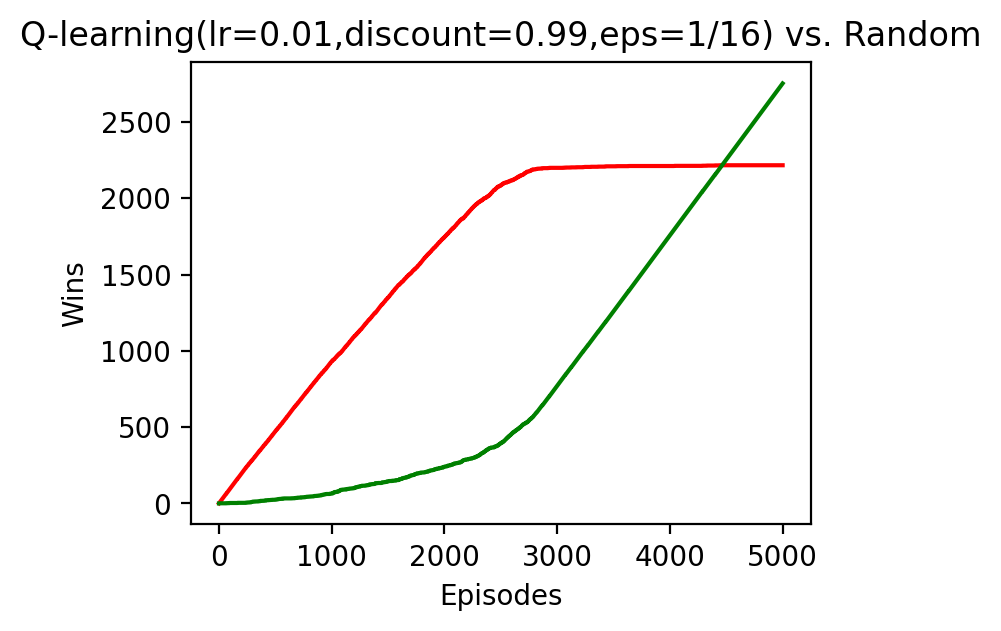

In [962]:
# Tournaments (5 per agent)
#p1 = RandomAgent(1)
p1 = Baseline(1)
#p2 = MC_agent(0.01, 2, 1)
#p2 = TD_learning(0.01, 2, 0.99, 26, (1/16))
p2 = Q_learning(2,0.01,0.99,(1/16))
#p2 = REINFORCE(2, 0.99, 0.005)
game = GOPS()
episodes = 5000
x = range(0,5000)

tourney = Tournament(game, p1, p2)
wins_p1, wins_p2, earnings_p1, earnings_p2 = tourney.runContest(episodes)
p1_win_record = np.zeros(episodes)
p2_win_record = np.zeros(episodes)
p1_win_record[0] = wins_p1[0]
p2_win_record[0] = wins_p2[0]
for i in range(1, episodes):
    p1_win_record[i] = p1_win_record[i-1]+wins_p1[i]
    p2_win_record[i] = p2_win_record[i-1]+wins_p2[i]
    
plt.figure(figsize=(4,3), dpi=200)
plt.plot(x, p1_win_record, color = "red")
plt.plot(x, p2_win_record, color = "green")
plt.title("Q-learning(lr=0.01,discount=0.99,eps=1/16) vs. Random")
plt.xlabel('Episodes') 
plt.ylabel('Wins')
plt.show()
    

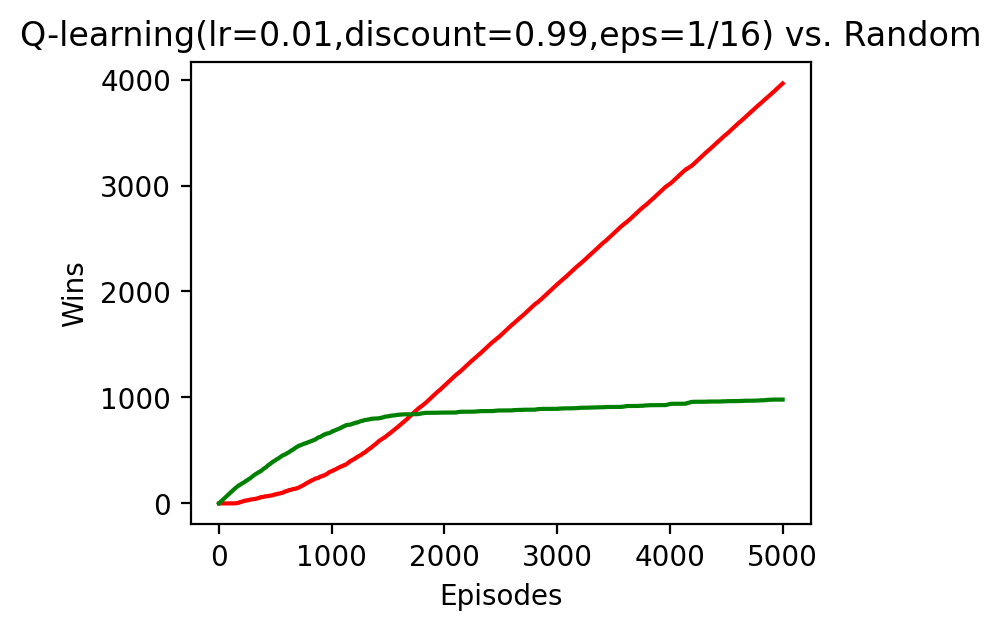

In [970]:
# Tournaments (6 total) (or 10 if we do 5 agents)
#p1 = RandomAgent(1)
p1 = Baseline(2)
p3 = MC_agent(0.01, 1, 2)
#p2 = TD_learning(0.01, 2, 0.99, 26, (1/16))
#p2 = Q_learning(2,0.01,0.99,(1/16))
#p2 = REINFORCE(2, 0.99, 0.005)
game = GOPS()
episodes = 5000
x = range(0,5000)

tourney = Tournament(game, p3, p1)
wins_p1, wins_p2, earnings_p1, earnings_p2 = tourney.runContest(episodes)
p1_win_record = np.zeros(episodes)
p2_win_record = np.zeros(episodes)
p1_win_record[0] = wins_p1[0]
p2_win_record[0] = wins_p2[0]
for i in range(1, episodes):
    p1_win_record[i] = p1_win_record[i-1]+wins_p1[i]
    p2_win_record[i] = p2_win_record[i-1]+wins_p2[i]
    
plt.figure(figsize=(4,3), dpi=200)
plt.plot(x, p1_win_record, color = "red")
plt.plot(x, p2_win_record, color = "green")
plt.title("Q-learning(lr=0.01,discount=0.99,eps=1/16) vs. Random")
plt.xlabel('Episodes') 
plt.ylabel('Wins')
plt.show()

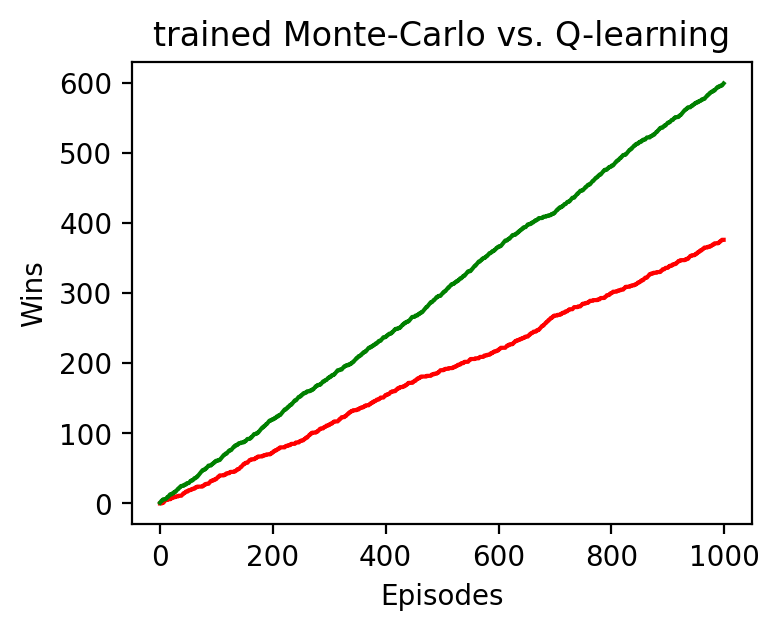

In [972]:
# Tournaments (6 total) (or 10 if we do 5 agents)
#p1 = RandomAgent(1)
#p1 = Baseline(1)
#p2 = MC_agent(0.01, 2, 1)
#p2 = TD_learning(0.01, 2, 0.99, 26, (1/16))
#p2 = Q_learning(2,0.01,0.99,(1/16))
#p2 = REINFORCE(2, 0.99, 0.005)
game = GOPS()
episodes = 1000
x = range(0,1000)

tourney = Tournament(game, p3, p2)
wins_p1, wins_p2, earnings_p1, earnings_p2 = tourney.runContest(episodes)
p1_win_record = np.zeros(episodes)
p2_win_record = np.zeros(episodes)
p1_win_record[0] = wins_p1[0]
p2_win_record[0] = wins_p2[0]
for i in range(1, episodes):
    p1_win_record[i] = p1_win_record[i-1]+wins_p1[i]
    p2_win_record[i] = p2_win_record[i-1]+wins_p2[i]
    
plt.figure(figsize=(4,3), dpi=200)
plt.plot(x, p1_win_record, color = "red")
plt.plot(x, p2_win_record, color = "green")
plt.title("trained Monte-Carlo vs. Q-learning")
plt.xlabel('Episodes') 
plt.ylabel('Wins')
plt.show()

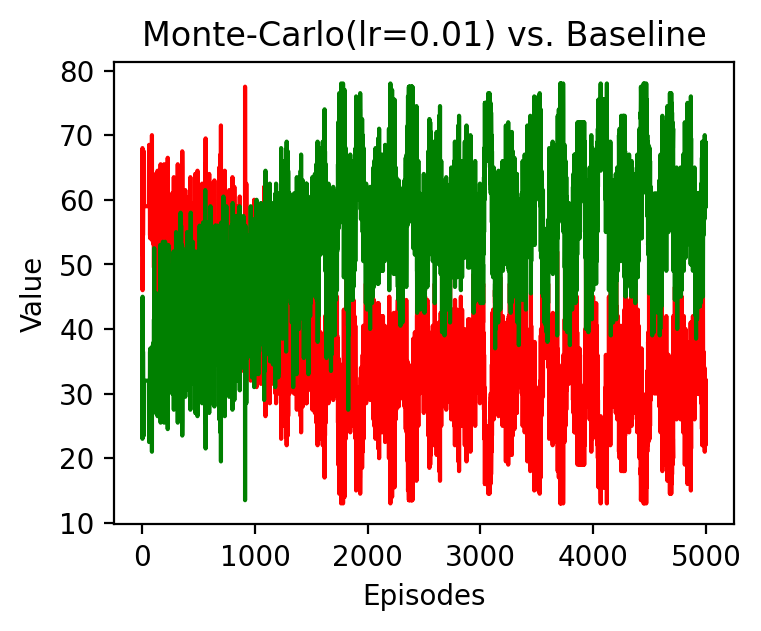

In [960]:
plt.figure(figsize=(4,3), dpi=200)
plt.plot(x, earnings_p1, color = "red")
plt.plot(x, earnings_p2, color = "green")
plt.title("Monte-Carlo(lr=0.01) vs. Baseline")
plt.xlabel('Episodes') 
plt.ylabel('Value')
plt.show()

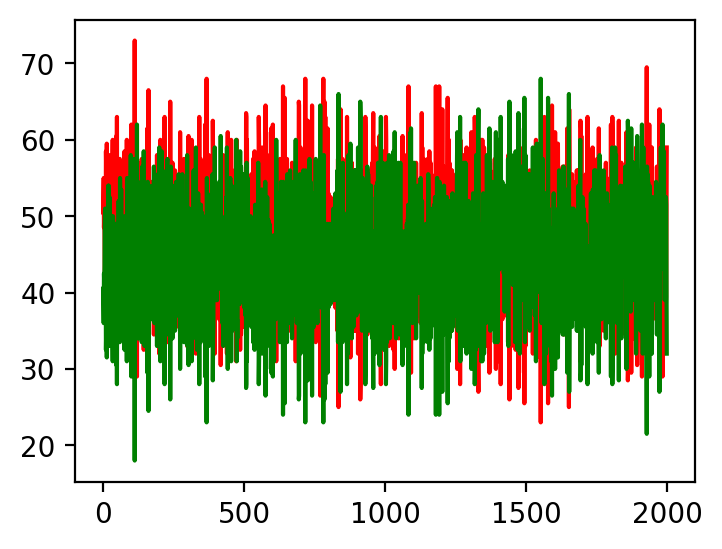

In [906]:
p1 = Baseline(1)
#p2 = MC_agent(0.01, 2, 1)
#p2 = Q_learning(0.001, 2, 0.99, 26, (1/16))
#p2 = Q_learning(2,(1/64),0.99,(1/16))
p2 = REINFORCE(2, 1, 0.05)
game = GOPS()
episodes = 2000
x = range(0,2000)

tourney = Tournament(game, p1, p2)
wins_p1, wins_p2, earnings_p1, earnings_p2 = tourney.runContest(episodes)
p1_win_record = np.zeros(episodes)
p2_win_record = np.zeros(episodes)
p1_win_record[0] = wins_p1[0]
p2_win_record[0] = wins_p2[0]
for i in range(1, episodes):
    p1_win_record[i] = p1_win_record[i-1]+wins_p1[i]
    p2_win_record[i] = p2_win_record[i-1]+wins_p2[i]
    
plt.figure(figsize=(4,3), dpi=200)
plt.plot(x, earnings_p1, color = "red")
plt.plot(x, earnings_p2, color = "green")
plt.show()

In [272]:
# I want to have a section on pitting agents trained against one adversary against an agent with a completely different
# policy. This could show how good the learned policy is at generalizing its strategy.

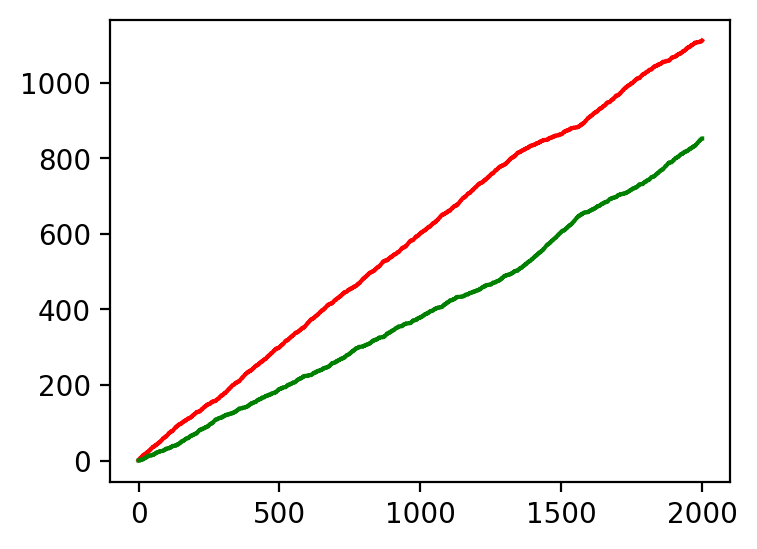

In [907]:
plt.figure(figsize=(4,3), dpi=200)
plt.plot(x, p1_win_record, color = "red")
plt.plot(x, p2_win_record, color = "green")
plt.show()

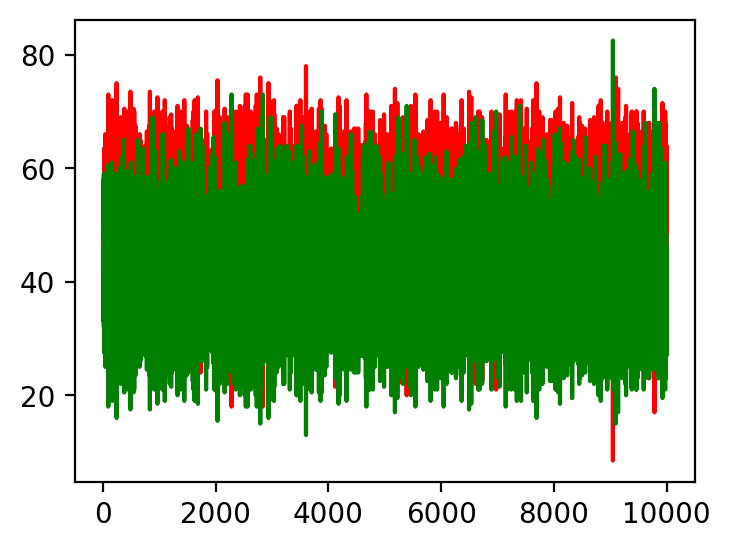

In [678]:
p1 = MC_agent(0.01, 1, 2)
#p2 = MC_agent(0.01, 2, 1)
#p2 = Q_learning(0.001, 2, 0.99, 26, (1/16))
p2 = Q_learning(2,0.01,0.99,(1/16))
game = GOPS()
episodes = 10000
x = range(0,10000)

tourney = Tournament(game, p1, p2)
wins_p1, wins_p2, earnings_p1, earnings_p2 = tourney.runContest(episodes)
p1_win_record = np.zeros(episodes)
p2_win_record = np.zeros(episodes)
p1_win_record[0] = wins_p1[0]
p2_win_record[0] = wins_p2[0]
for i in range(1, episodes):
    p1_win_record[i] = p1_win_record[i-1]+wins_p1[i]
    p2_win_record[i] = p2_win_record[i-1]+wins_p2[i]
    
plt.figure(figsize=(4,3), dpi=200)
plt.plot(x, earnings_p1, color = "red")
plt.plot(x, earnings_p2, color = "green")
plt.show()

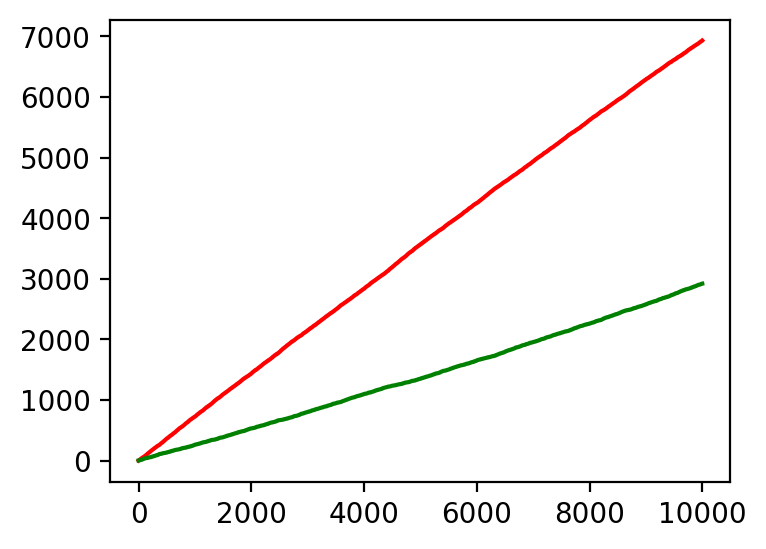

In [679]:
plt.figure(figsize=(4,3), dpi=200)
plt.plot(x, p1_win_record, color = "red")
plt.plot(x, p2_win_record, color = "green")
plt.show()